$ \newcommand{\Bra}[1]{\left\langle #1 \right|} $
$ \newcommand{\Ket}[1]{\left| #1 \right\rangle} $

# March Meeting 2021

In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [2]:
import os.path as op

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e as e_charge
from scipy.constants import hbar, mega
from scipy.optimize import fsolve
import sympy as sp
from sympy.physics.matrices import msigma

import nmrlib.core as nmr
import nmrlib.quantum as quant
from src import ROOT
from src.utils import find_max_min

FIGSIZE = mpl.rcParams["figure.figsize"]

class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

## Eigenstates and eigenenergies

The first step is to find the states and energies. We first define the spin operators.

In [3]:
I = sp.Rational(3, 2)
sym = Bunch({})
sym.I = {}
sym.I['y'] = sp.Matrix([[0, -sp.I*sp.sqrt(3), 0, 0], [sp.I*sp.sqrt(3), 0, -sp.I*2, 0], [0, sp.I*2, 0, -sp.I*sp.sqrt(3)], [0, 0, sp.I*sp.sqrt(3), 0]])/2
sym.I['x'] = sp.Matrix([[0, sp.sqrt(3), 0, 0], [sp.sqrt(3), 0, 2, 0], [0, 2, 0, sp.sqrt(3)], [0, 0, sp.sqrt(3), 0]])/2
sym.I['z'] = sp.Matrix([[I, 0, 0, 0], [0, I - 1, 0, 0], [0, 0, I - 2, 0], [0, 0, 0, I - 3]])
for i in ['x', 'y', 'z']:
    display(sym.I[i])

Matrix([
[        0, sqrt(3)/2,         0,         0],
[sqrt(3)/2,         0,         1,         0],
[        0,         1,         0, sqrt(3)/2],
[        0,         0, sqrt(3)/2,         0]])

Matrix([
[          0, -sqrt(3)*I/2,           0,            0],
[sqrt(3)*I/2,            0,          -I,            0],
[          0,            I,           0, -sqrt(3)*I/2],
[          0,            0, sqrt(3)*I/2,            0]])

Matrix([
[3/2,   0,    0,    0],
[  0, 1/2,    0,    0],
[  0,   0, -1/2,    0],
[  0,   0,    0, -3/2]])

It is easier to create Hamiltonian in quadrupolar basis first.

In [4]:
sym.alpha, sym.delta = sp.symbols('alpha delta', real=True, positive=True)
sym.X = [None]*4
sym.Xp = [None]*4
sym.X[0] = sp.eye(4)[:, 0]
sym.X[1] = sp.eye(4)[:, 1]
sym.X[2] = sp.eye(4)[:, 2]
sym.X[3] = sp.eye(4)[:, 3]
sym.Xp[0] = sp.cos(sym.delta)*sym.X[0] + sp.sin(sym.delta)*sym.X[2]
sym.Xp[3] = sp.cos(sym.delta)*sym.X[3] + sp.sin(sym.delta)*sym.X[1]
sym.Xp[1] = sp.cos(sym.delta)*sym.X[1] - sp.sin(sym.delta)*sym.X[3]
sym.Xp[2] = sp.cos(sym.delta)*sym.X[2] - sp.sin(sym.delta)*sym.X[0]
Hq = np.diag([1, -1, -1, 1]) # Quadrupolar Hamiltonian divided by alpha
Hz = sp.Matrix(np.zeros([4, 4], dtype=object)) # Zeeman Hamiltonian
for i in range(4):
    for j in range(4):
        Hz[i, j] = sym.Xp[i].dot(sym.I['z']*sym.Xp[j])
TRIGSUBS = {sp.sin(sym.delta)**2: (1 - sp.cos(2*sym.delta))/2, sp.cos(sym.delta)**2: (sp.cos(2*sym.delta) + 1)/2}
Hz = sp.simplify(Hz).subs(TRIGSUBS)
sym.H_qbasis = sp.simplify(sp.Matrix(sym.alpha*Hq + Hz))
sym.H_qbasis

Matrix([
[alpha + cos(2*delta) + 1/2,                           0,               -sin(2*delta),                          0],
[                         0, -alpha + cos(2*delta) - 1/2,                           0,               sin(2*delta)],
[             -sin(2*delta),                           0, -alpha - cos(2*delta) + 1/2,                          0],
[                         0,                sin(2*delta),                           0, alpha - cos(2*delta) - 1/2]])

Find eigenvalues and eigenvectors in quadrupolar basis.

In [5]:
a, b, c, d, f = sp.symbols('a b c d f')
H_temp = sp.Matrix([[a, 0, -f, 0], [0, b, 0, f], [-f, 0, c, 0], [0, f, 0, d]])
sym.eig_qbasis = H_temp.eigenvects()
H_temp

Matrix([
[ a, 0, -f, 0],
[ 0, b,  0, f],
[-f, 0,  c, 0],
[ 0, f,  0, d]])

In [6]:
Hsubs = {a: sym.H_qbasis[0, 0], b: sym.H_qbasis[1, 1], c: sym.H_qbasis[2, 2], d: sym.H_qbasis[3, 3],
         f: sym.H_qbasis[1, 3]}
for i in range(4):
    E, X = sp.simplify(sym.eig_qbasis[i][0].subs(Hsubs)), sp.simplify(sym.eig_qbasis[i][2][0].subs(Hsubs))
    display(E)#.subs({sym.delta: 0, sym.alpha: 0}))
    display(X)#.subs(sym.delta, 0))  
    print('='*80)

1/2 - sqrt(alpha**2 - 4*alpha*sin(delta)**2 + 2*alpha + 1)

Matrix([
[sin(2*delta)/(alpha + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                              0],
[                                                                              1],
[                                                                              0]])

sqrt(alpha**2 - 4*alpha*sin(delta)**2 + 2*alpha + 1) + 1/2

Matrix([
[sin(2*delta)/(alpha - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                              0],
[                                                                              1],
[                                                                              0]])

-sqrt(alpha**2 + 4*alpha*sin(delta)**2 - 2*alpha + 1) - 1/2

Matrix([
[                                                                              0],
[sin(2*delta)/(alpha - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))],
[                                                                              0],
[                                                                              1]])

sqrt(alpha**2 + 4*alpha*sin(delta)**2 - 2*alpha + 1) - 1/2

Matrix([
[                                                                              0],
[sin(2*delta)/(alpha + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))],
[                                                                              0],
[                                                                              1]])

Now change basis to Zeeman basis by a unitary operator $ U = \sum_k \Ket{b^{(k)}} \Bra{a^{(k)}} $ (assuming going from $ A $ basis to $ B $ basis).

In [7]:
sym.U = sp.zeros(4, 4)
for k in range(4):
    bk = sym.X[k]
    ak = sym.Xp[k]
    sym.U += bk*ak.T
sym.U

Matrix([
[ cos(delta),          0, sin(delta),           0],
[          0, cos(delta),          0, -sin(delta)],
[-sin(delta),          0, cos(delta),           0],
[          0, sin(delta),          0,  cos(delta)]])

The Hamiltonian and eigenvectors in the Zeeman basis are then $ U^\dagger H U $ and $ U^\dagger \Ket{m''} $, respectively. 

In [8]:
sym.H = sp.simplify(sp.simplify((sym.U.T*sym.H_qbasis*sym.U)).subs(TRIGSUBS))
sym.H

Matrix([
[alpha*cos(2*delta) + 3/2,                         0,        alpha*sin(2*delta),                        0],
[                       0, -alpha*cos(2*delta) + 1/2,                         0,       alpha*sin(2*delta)],
[      alpha*sin(2*delta),                         0, -alpha*cos(2*delta) - 1/2,                        0],
[                       0,        alpha*sin(2*delta),                         0, alpha*cos(2*delta) - 3/2]])

In [9]:
Hsubs = {a: sym.H_qbasis[0, 0], b: sym.H_qbasis[1, 1], c: sym.H_qbasis[2, 2], d: sym.H_qbasis[3, 3],
         f: sym.H_qbasis[1, 3]}
for i in range(4):
    E, X = sp.simplify(sym.eig_qbasis[i][0].subs(Hsubs)), sp.simplify(sym.U.T*(sym.eig_qbasis[i][2][0].subs(Hsubs)))
    display(E.subs(TRIGSUBS).simplify())#.subs({sym.delta: 0, sym.alpha: 0}))
    display((sym.U.T*sp.simplify(sym.eig_qbasis[i][2][0].subs(Hsubs))))
    display(X.subs(TRIGSUBS).simplify())#.subs(sym.delta, 0))  
    print('='*80)

1/2 - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1)

Matrix([
[-sin(delta) + sin(2*delta)*cos(delta)/(alpha + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                                                       0],
[ cos(delta) + sin(delta)*sin(2*delta)/(alpha + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                                                       0]])

Matrix([
[-(alpha + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) - 1)*sin(delta)/(alpha + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                                                                                     0],
[ (alpha + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + 1)*cos(delta)/(alpha + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                                                                                     0]])

sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + 1/2

Matrix([
[-sin(delta) + sin(2*delta)*cos(delta)/(alpha - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                                                       0],
[ cos(delta) + sin(delta)*sin(2*delta)/(alpha - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                                                       0]])

Matrix([
[(-alpha + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + 1)*sin(delta)/(alpha - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                                                                                     0],
[ (alpha - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + 1)*cos(delta)/(alpha - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + cos(2*delta))],
[                                                                                                                                     0]])

-sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - 1/2

Matrix([
[                                                                                                      0],
[sin(delta) + sin(2*delta)*cos(delta)/(alpha - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))],
[                                                                                                      0],
[cos(delta) - sin(delta)*sin(2*delta)/(alpha - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))]])

Matrix([
[                                                                                                                                    0],
[(alpha - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) + 1)*sin(delta)/(alpha - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))],
[                                                                                                                                    0],
[(alpha - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - 1)*cos(delta)/(alpha - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))]])

sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - 1/2

Matrix([
[                                                                                                      0],
[sin(delta) + sin(2*delta)*cos(delta)/(alpha + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))],
[                                                                                                      0],
[cos(delta) - sin(delta)*sin(2*delta)/(alpha + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))]])

Matrix([
[                                                                                                                                    0],
[(alpha + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) + 1)*sin(delta)/(alpha + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))],
[                                                                                                                                    0],
[(alpha + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - 1)*cos(delta)/(alpha + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - cos(2*delta))]])

Alternatively, I propose that the eigenvalues and eigenvectors are defined in the following way:

In [10]:
sym.gp, sym.gm, sym.Ap, sym.Am = sp.symbols('g_{+} g_{-} A_{+} A_{-}', real=True)

def gj(j):
    #return sym.alpha + sp.sqrt((sym.alpha + j*sp.cos(sym.D))**2 + sp.sin(sym.D)**2)
    return sp.sign(sym.alpha + j*sp.cos(2*sym.delta))\
           *sp.sqrt((sym.alpha + j*sp.cos(2*sym.delta))**2 + sp.sin(2*sym.delta)**2)

def sym_gj(j):
    return {+1: sym.gp, -1: sym.gm}[j]
    
def Aj(j):
    #return 1/((sym_gj(j) + j*sp.cos(sym.D))*sp.sqrt(1 + (sp.sin(sym.D)/(sym_gj(j) + j*sp.cos(sym.D)))**2))
    #return 1/sp.sqrt((sym_gj(j) + j*sp.cos(sym.D))**2 + sp.sin(sym.D)**2)
    return sp.sign(sym.alpha + sym_gj(j) + j*sp.cos(2*sym.delta))\
           /sp.sqrt((sym.alpha + sym_gj(j) + j*sp.cos(2*sym.delta))**2 + sp.sin(2*sym.delta)**2)

def sym_Aj(j):
    return {1: sym.Ap, -1: sym.Am}[j]

GSUBS = {sym.gp: gj(+1), sym.gm: gj(-1)}
ASUBS = {sym.Ap: Aj(+1), sym.Am: Aj(-1)}

sym.Epp = {}
sym.Xpp = {}
sym.Xpp['3/2'] = ((sym.alpha + sym.gp + 1)*sp.cos(sym.delta)*sym.X[0]
                + (sym.alpha + sym.gp - 1)*sp.sin(sym.delta)*sym.X[2])*sym.Ap
sym.Xpp['-3/2'] = ((sym.alpha + sym.gm - 1)*sp.cos(sym.delta)*sym.X[3]
                 + (sym.alpha + sym.gm + 1)*sp.sin(sym.delta)*sym.X[1])*sym.Am
sym.Xpp['1/2'] = ((sym.alpha + sym.gm - 1)*sp.cos(sym.delta)*sym.X[1]
                - (sym.alpha + sym.gm + 1)*sp.sin(sym.delta)*sym.X[3])*sym.Am
sym.Xpp['-1/2'] = ((sym.alpha + sym.gp + 1)*sp.cos(sym.delta)*sym.X[2]
                 - (sym.alpha + sym.gp - 1)*sp.sin(sym.delta)*sym.X[0])*sym.Ap
sym.Epp['3/2'] = sym.gp + sp.Rational(1, 2)
sym.Epp['-3/2'] = sym.gm - sp.Rational(1, 2)
sym.Epp['1/2'] = -(sym.gm + sp.Rational(1, 2))
sym.Epp['-1/2'] = -(sym.gp - sp.Rational(1, 2))

In [11]:
for i in ['3/2', '1/2', '-1/2', '-3/2']:
    print(i)
    display(sym.Epp[i])
    display(sym.Xpp[i])
    print('='*80)

3/2


g_{+} + 1/2

Matrix([
[A_{+}*(alpha + g_{+} + 1)*cos(delta)],
[                                   0],
[A_{+}*(alpha + g_{+} - 1)*sin(delta)],
[                                   0]])

1/2


-g_{-} - 1/2

Matrix([
[                                    0],
[ A_{-}*(alpha + g_{-} - 1)*cos(delta)],
[                                    0],
[-A_{-}*(alpha + g_{-} + 1)*sin(delta)]])

-1/2


1/2 - g_{+}

Matrix([
[-A_{+}*(alpha + g_{+} - 1)*sin(delta)],
[                                    0],
[ A_{+}*(alpha + g_{+} + 1)*cos(delta)],
[                                    0]])

-3/2


g_{-} - 1/2

Matrix([
[                                   0],
[A_{-}*(alpha + g_{-} + 1)*sin(delta)],
[                                   0],
[A_{-}*(alpha + g_{-} - 1)*cos(delta)]])

Let us first verify that these are in fact eigenvalues and eigenvectors of the Hamiltonian by checking if $ H \Ket{m''} - E_{m''} \Ket{m''} = 0 $

In [12]:
alpha = np.linspace(0, 10)
delta = np.linspace(0, np.pi/12)
for i in sym.Epp:
    E, X = sym.Epp[i].subs(GSUBS), (sym.Xpp[i].subs(ASUBS).subs(GSUBS))
    a, d = np.cos(np.pi/12), np.pi/25
    #display(E.subs(sym.delta, d).subs(sym.alpha, a))
    #display(X.subs(sym.delta, d).subs(sym.alpha, a))
    f = sp.lambdify([sym.alpha, sym.delta], sym.H*X - E*X)
    for a in alpha:
        for d in delta:
            if not np.all(np.isclose(f(a, d), 0)):
                print(f(a, d))

Since nothing printed, that means we have proper eigenvalues and eigenvectors. Let's also verify numerically.

In [13]:
def eigsort(E, X):
    idx = E.argsort()[::-1]   
    E_sorted = E[idx]
    X_sorted = X[:,idx]
    
    return (E_sorted, X_sorted)

alpha = np.linspace(0, 10, 10)
delta = np.linspace(0, np.pi/12, 10)
    #display(E.subs(sym.delta, d).subs(sym.alpha, a))
    #display(X.subs(sym.delta, d).subs(sym.alpha, a))
    #f = sp.lambdify([sym.alpha, sym.delta], sym.H*X - E*X)
for a in alpha:
    for d in delta:
        subsd = {sym.alpha: a, sym.delta: d}
        E_sym, X_sym = (np.zeros(4), np.zeros([4, 4]))
        for i, label in enumerate(sym.Epp):
            E, X = sym.Epp[label].subs(GSUBS), (sym.Xpp[label].subs(ASUBS).subs(GSUBS))
            E_sym[i] = np.float64(E.subs(subsd))
            X_sym[i] = np.squeeze(X.subs(subsd)).astype(np.float64)
        eig_sym = eigsort(E_sym, X_sym)
        H_num = np.array(sym.H.subs(subsd)).astype(np.float64)
        eig_num = eigsort(*np.linalg.eig(H_num))
        if not np.all(np.isclose(eig_num[0], eig_sym[0]) == True):
            print('eigenvalues')
            print(eig_num[0], eig_sym[0])
        if not np.all(np.isclose(eig_num[1], eig_sym[1]) == True):
            print('eigenvectors')
            print(eig_num[1])
            print(eig_sym[1])
        print('='*80)
#         print('unsorted')
#         print(eig_num[0])
#         print(eig_num[1])
#         eig_num = eigsort(*eig_num)
#         print('sorted')
#         print(eig_num[0])
#         print(eig_num[1])
#         print('='*80)

eigenvectors
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
eigenvectors
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 1.00000000e+00 -1.61520953e-18  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -1.61520953e-18]
 [ 0.00000000e+00  0.00000000e+00  1.61520953e-18  1.00000000e+00]
 [ 1.61520953e-18  1.00000000e+00  0.00000000e+00  0.00000000e+00]]
eigenvectors
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
eigenvectors
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 1.00000000e+00 -4.85659643e-18  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -4.85659643e-18]
 [ 0.00000000e+00  0.00000000e+00  4.85659643e-18  1.00000000e+00]
 [ 4.85659643e-18  1.00000000e+00  0.00000000e+00  0.00000000e+00]]
eigenvectors
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 

eigenvectors
[[ 0.98356615  0.          0.          0.18054816]
 [ 0.         -0.4244983   0.90542873  0.        ]
 [ 0.18054816  0.          0.         -0.98356615]
 [ 0.         -0.90542873 -0.4244983   0.        ]]
[[ 0.98356615  0.          0.18054816  0.        ]
 [ 0.          0.4244983   0.          0.90542873]
 [ 0.          0.90542873  0.         -0.4244983 ]
 [-0.18054816  0.          0.98356615  0.        ]]
eigenvectors
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
eigenvectors
[[ 0.99974963  0.          0.          0.02237572]
 [ 0.         -0.04152488  0.99913747  0.        ]
 [ 0.02237572  0.          0.         -0.99974963]
 [ 0.         -0.99913747 -0.04152488  0.        ]]
[[ 0.99974963  0.          0.02237572  0.        ]
 [ 0.          0.04152488  0.          0.99913747]
 [ 0.          0.99913747  0.         -0.04152488]
 [-0.02237572  0.          0.99974963  0.        ]]
eigenvectors
[[ 0.9

eigenvectors
[[ 0.98046755  0.          0.          0.19668092]
 [ 0.         -0.27702567  0.96086252  0.        ]
 [ 0.19668092  0.          0.         -0.98046755]
 [ 0.         -0.96086252 -0.27702567  0.        ]]
[[ 0.98046755  0.          0.19668092  0.        ]
 [ 0.          0.27702567  0.          0.96086252]
 [ 0.          0.96086252  0.         -0.27702567]
 [-0.19668092  0.          0.98046755  0.        ]]
eigenvectors
[[ 0.97525019  0.          0.          0.22110421]
 [ 0.         -0.30972994  0.95082457  0.        ]
 [ 0.22110421  0.          0.         -0.97525019]
 [ 0.         -0.95082457 -0.30972994  0.        ]]
[[ 0.97525019  0.          0.22110421  0.        ]
 [ 0.          0.30972994  0.          0.95082457]
 [ 0.          0.95082457  0.         -0.30972994]
 [-0.22110421  0.          0.97525019  0.        ]]
eigenvectors
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
eigenvectors
[[ 0.9

eigenvectors
[[ 0.97223571  0.          0.          0.2340037 ]
 [ 0.         -0.28874915  0.95740479  0.        ]
 [ 0.2340037   0.          0.         -0.97223571]
 [ 0.         -0.95740479 -0.28874915  0.        ]]
[[ 0.97223571  0.          0.2340037   0.        ]
 [ 0.          0.28874915  0.          0.95740479]
 [ 0.          0.95740479  0.         -0.28874915]
 [-0.2340037   0.          0.97223571  0.        ]]
eigenvectors
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
eigenvectors
[[ 0.99965034  0.          0.          0.02644241]
 [ 0.         -0.03231281  0.9994778   0.        ]
 [ 0.02644241  0.          0.         -0.99965034]
 [ 0.         -0.9994778  -0.03231281  0.        ]]
[[ 0.99965034  0.          0.02644241  0.        ]
 [ 0.          0.03231281  0.          0.9994778 ]
 [ 0.          0.9994778   0.         -0.03231281]
 [-0.02644241  0.          0.99965034  0.        ]]
eigenvectors
[[ 0.9

## Transition Frequencies

Now we find all allowed transition frequencies (negative ones are excluded).

In [14]:
sym.freq = {}
for i in sym.Epp:
    for j in sym.Epp:
        Xi, Xj = sym.Xpp[i], sym.Xpp[j]
            #m = sp.simplify((Xi.T*sym.I[d]*Xj)[0])
            #if m != 0 and i != j and (i, j) not in exclude: # if transition is not zero and frequency is > 0
        if i != j: # if transition is not zero
            Ei, Ej = sym.Epp[i], sym.Epp[j]
            sym.freq[(i, j)] = sym.Epp[j] - sym.Epp[i]
            print(f'{i} -> {j}')
            display(sym.freq[(i, j)])
            print('-'*15)

3/2 -> -3/2


-g_{+} + g_{-} - 1

---------------
3/2 -> 1/2


-g_{+} - g_{-} - 1

---------------
3/2 -> -1/2


-2*g_{+}

---------------
-3/2 -> 3/2


g_{+} - g_{-} + 1

---------------
-3/2 -> 1/2


-2*g_{-}

---------------
-3/2 -> -1/2


-g_{+} - g_{-} + 1

---------------
1/2 -> 3/2


g_{+} + g_{-} + 1

---------------
1/2 -> -3/2


2*g_{-}

---------------
1/2 -> -1/2


-g_{+} + g_{-} + 1

---------------
-1/2 -> 3/2


2*g_{+}

---------------
-1/2 -> -3/2


g_{+} + g_{-} - 1

---------------
-1/2 -> 1/2


g_{+} - g_{-} - 1

---------------


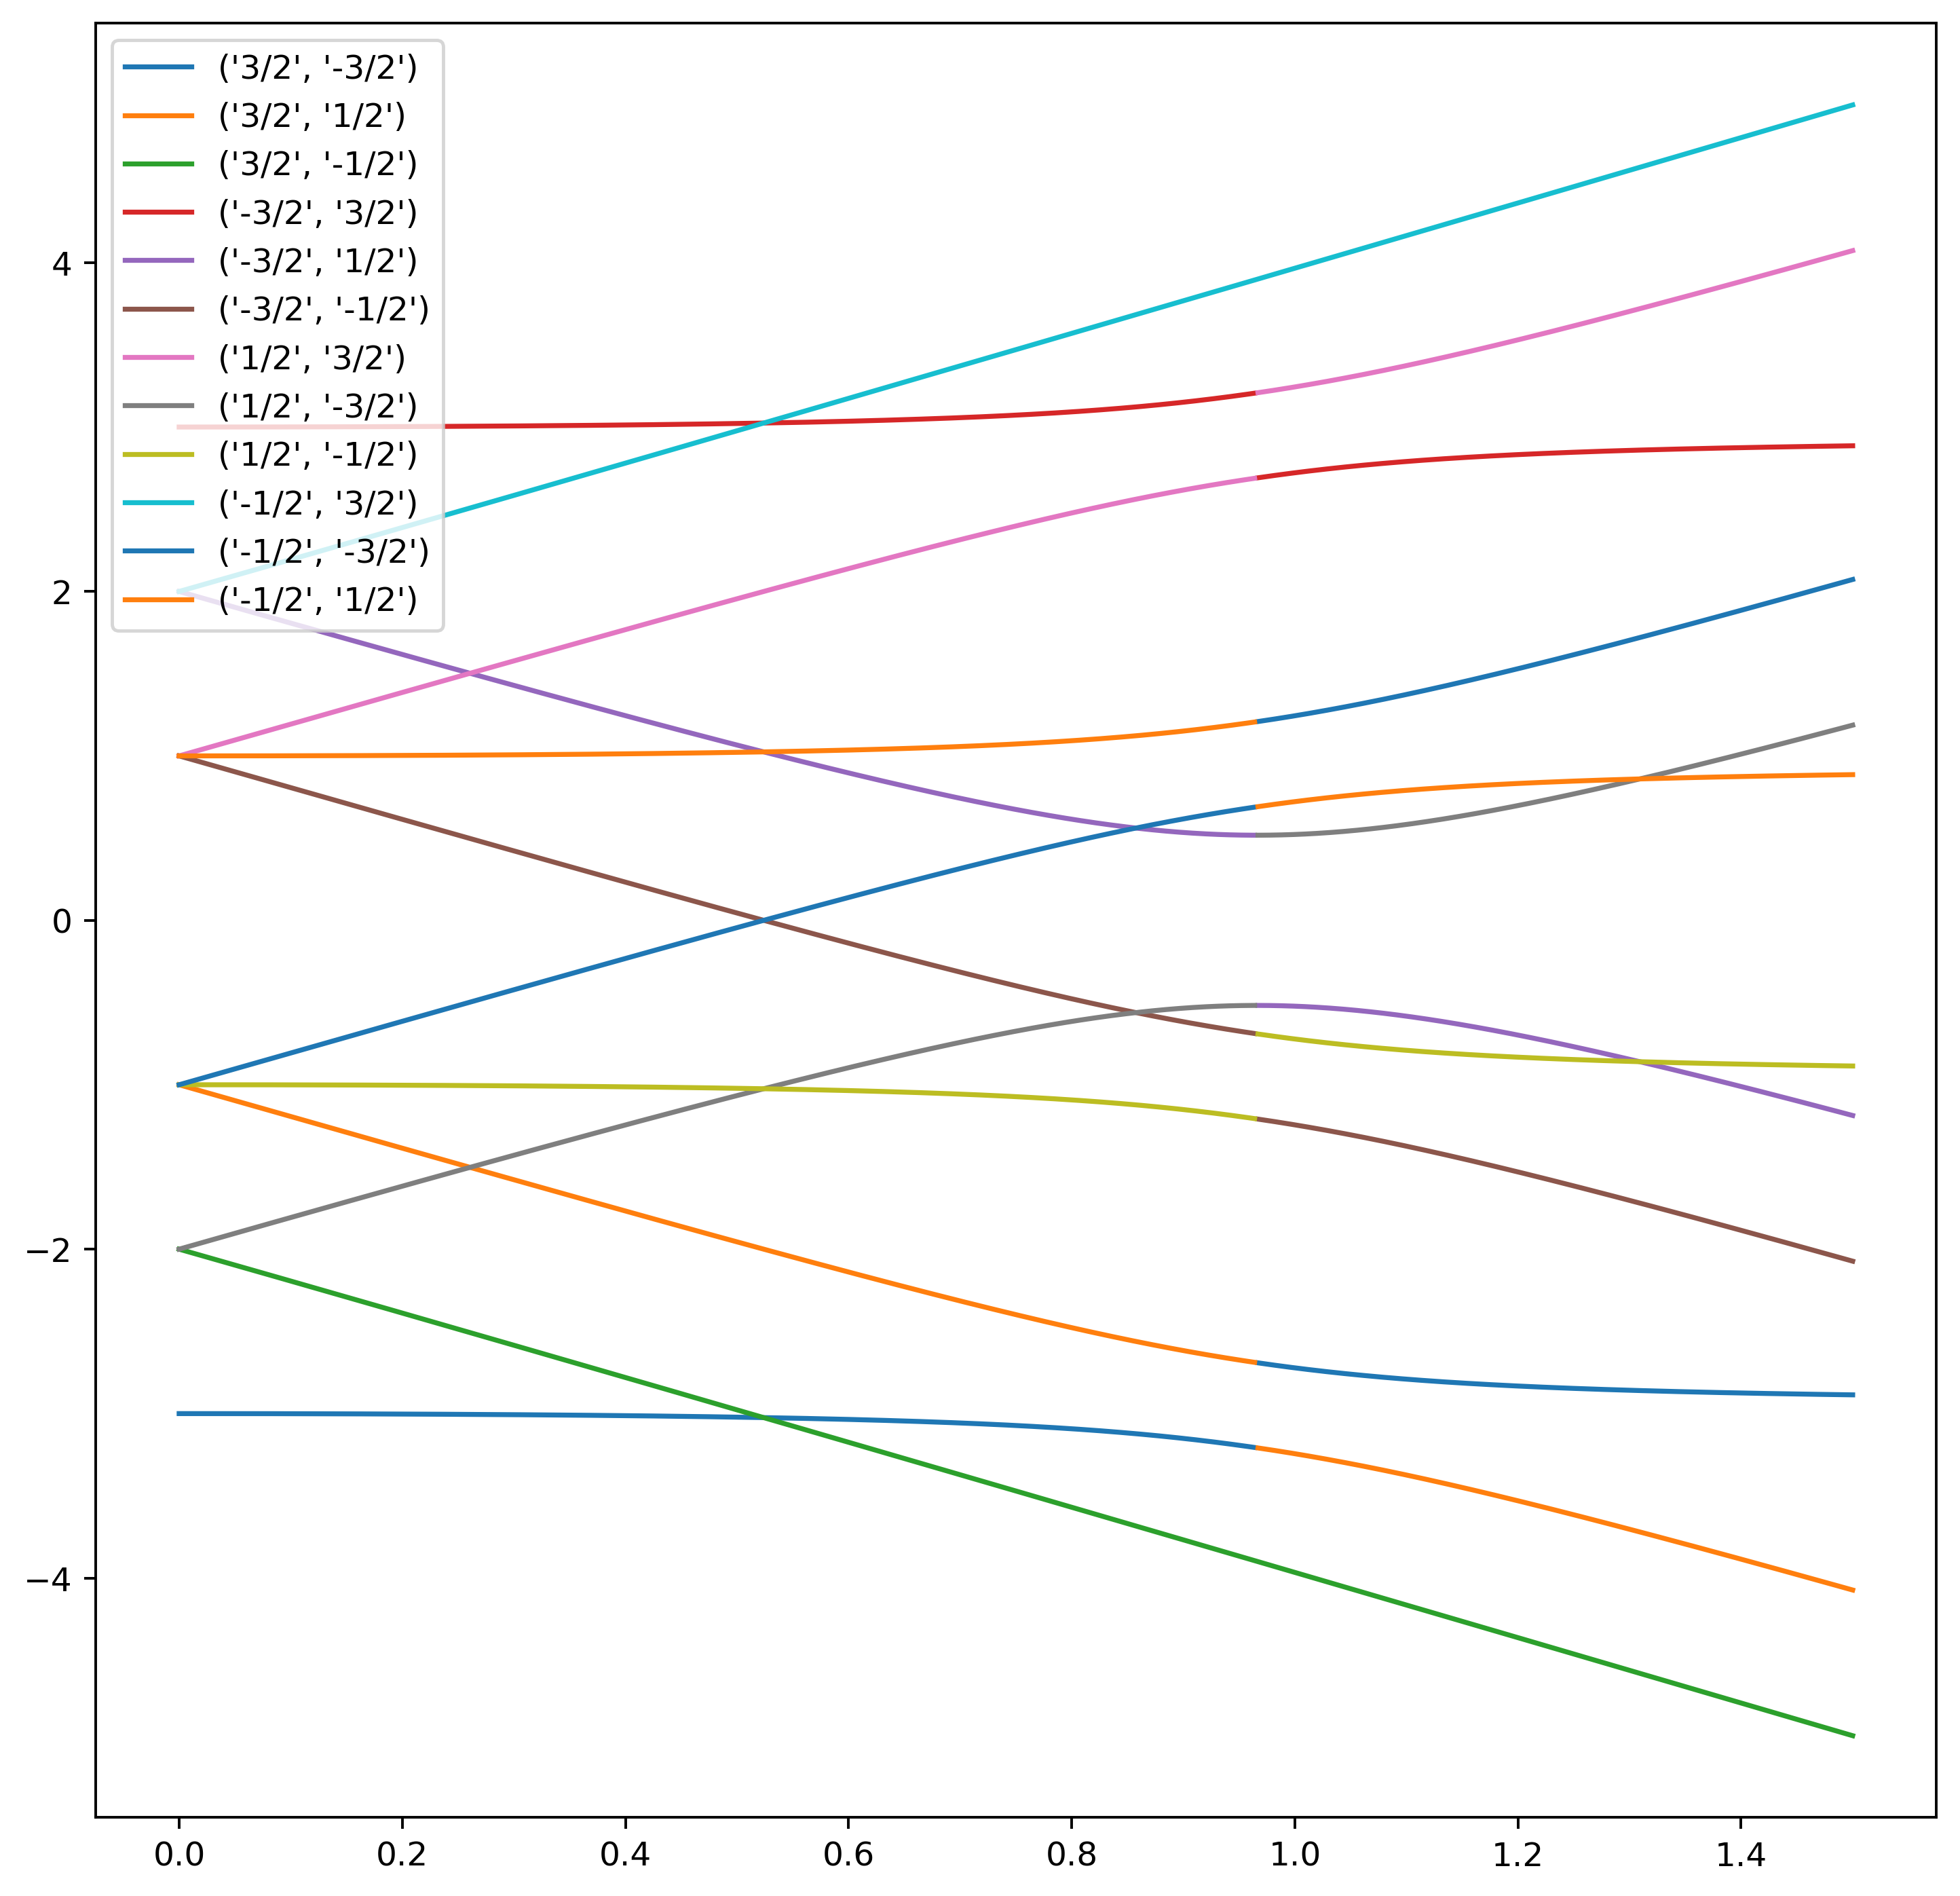

In [15]:
fig, ax = plt.subplots(figsize=[10,10], dpi=350)
alpha = np.linspace(0, 1.5, 1000)
delta = np.pi/24
for i in sym.freq:
    _f = sym.freq[i].subs(GSUBS)
    f = sp.lambdify([sym.alpha, sym.delta], _f)
    y = f(alpha, delta)
    y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
    ax.plot(alpha, y, label=i)
    if i == ('3/2', '1/2'):
        pass#break
ax.legend()

Some of these transitions will be weaker than others, so we calculate the magnetic moment of each frequency to determine its intensity. We first create Python lambda functions that we can use to store the magnetic moment expressions and treat as Python functions.

In [16]:
sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
sym.Iexp = {}
sym.Iexp['x'] = {}
sym.Iexp['y'] = {}
sym.Iexp['z'] = {}
up = sp.Matrix([1, 0])
down = sp.Matrix([0, 1])
c = [None]*3
c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
beta = {}
beta['x'] = {}#sp.Matrix(np.zeros((4, 4)))
beta['y'] = {}#sp.Matrix(np.zeros((4, 4)))
beta['z'] = {}#sp.Matrix(np.zeros((4, 4)))
for d in ['x', 'y', 'z']:
    for i, tran in enumerate(sym.freq):
        p, q = tran
        Xp, Xq = sym.Xpp[p], sym.Xpp[q]
        wpq = sym.freq[tran]
        beta = sp.simplify(Xp.T*sym.I[d]*Xq)
        #beta[d][tran] = sp.simplify(Xp.T*sym.I[d]*Xq)
        compi, compj = 0, 0
        for m, d2 in enumerate(['x', 'y', 'z']):
            betam = (Xp.T*sym.I[d2]*Xq)[0]
            compi += c[m]*sp.re(betam)
            compj += c[m]*sp.im(betam)
        if compi != 0 or compj != 0:
            nhat = (sp.Matrix([compi, compj, 0])/sp.sqrt(compi**2 + compj**2))
            Vmid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
            _Iexp = wpq/(2*(2*I + 1))*(down.T*Vmid*up)*beta*sp.exp(sp.I*wpq*sym.t)
            Iexp = _Iexp[0]# + sp.conjugate(_Iexp[0])
            sym.Iexp[d][tran] = sp.lambdify([sym.alpha, sym.delta, sym.t], Iexp.subs(ASUBS).subs(GSUBS))
        #else:
        #    sym.Iexp[d][tran] = sp.lambdify([sym.alpha, sym.delta, sym.t], 0)

In [17]:
sym.Iexp

{'x': {('3/2', '-3/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('3/2', '1/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('-3/2', '3/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('-3/2', '-1/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('1/2', '3/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('1/2', '-1/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('-1/2', '-3/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('-1/2', '1/2'): <function _lambdifygenerated(alpha, delta, t)>},
 'y': {('3/2', '-3/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('3/2', '1/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('-3/2', '3/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('-3/2', '-1/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('1/2', '3/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('1/2', '-1/2'): <function _lambdifygenerated(alpha, delta, t)>,
  ('-1/2', '-3/2'): <function _lambdifygenerated(alp

With the functions defined, we can now visualize the spectrum.

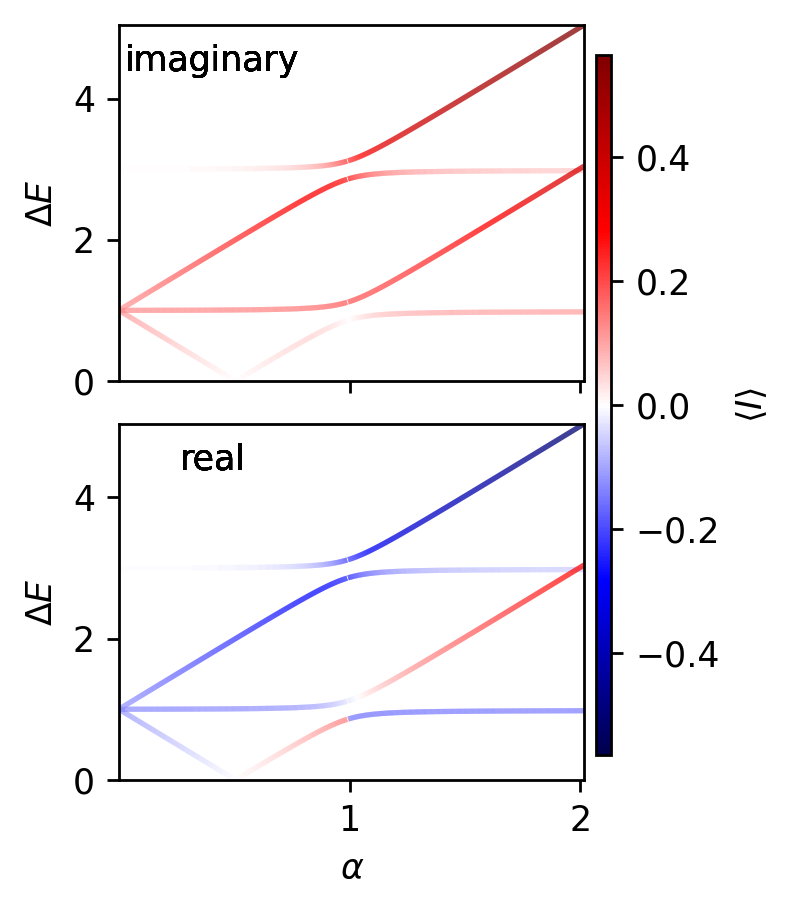

In [43]:
delta = np.arccos(0.9917172851021455)/2#np.pi/6
alpha = np.linspace(0, 2, 1000)[1:]/np.cos(2*delta)
xdata = {}
ydata = {}
cdata = {}
for i, d in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[d]
    xdata[d] = {}
    ydata[d] = {}
    cdata[d] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        wpq = sp.lambdify([sym.alpha, sym.delta], sym.freq[tran].subs(GSUBS))(alpha, delta)
        x = alpha.copy()#[wpq >= 0]
        y = wpq.copy()*np.sign(alpha)#[wpq >= 0]
        y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
        _Iexp = Iexp[tran](alpha, delta, 0)
        if np.any(_Iexp != 0):
            c = _Iexp#[wpq >= 0]
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = (c).copy()
        else:
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = np.zeros(alpha.size)

fig, ax = plt.subplots(nrows=2, ncols=1,
                       sharex=True,
                       sharey=True,
                       gridspec_kw = {'hspace': 0.12, 'wspace': 0},
                       figsize=(FIGSIZE[0]/2.5, FIGSIZE[1]),
                       dpi=250)
cmin, cmax = 100, -100
for i, d in enumerate(cdata):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    if len(cdata_list) != 0:
        for k in [0, 1]:
            func = {0: np.real, 1: np.imag}
            _cmax, _cmin = find_max_min([func[k](c) for c in cdata_list])
            if _cmax > cmax:
                cmax = _cmax
            if _cmin < cmin:
                cmin = _cmin
#cmin, cmax = -0.4, 0.4#0.05/1000
#ymin, ymax = 0, 4
for i, d in enumerate(['x', 'y']):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    ymax, ymin = find_max_min(ydata_list)
    norm = plt.Normalize(cmin, cmax)
    for j, tran in enumerate(cdata[d]):
        x = xdata[d][tran]
        y = ydata[d][tran]
        if d == 'x':
            choice = [1]
        elif d == 'y':
            choice = [0]
        trig_func = {1: r'imaginary', 0: r'real'}
        for k in choice:
            func = {0: np.real, 1: np.imag}
            c = func[k](cdata[d][tran])
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = mpl.collections.LineCollection(segments, cmap='seismic', norm=norm)
            lc.set_array(c)
            line = ax[i].add_collection(lc)
            ax[i].set_xlim(alpha.min(), alpha.max())
            ax[i].set_ylim(0, ymax)
            ax[i].set_facecolor("white")
            ax[i].text(0.2, 0.9,
                       trig_func[k],
                       color='k',
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax[i].transAxes)
            ax[-1].set_xlabel(r'$\alpha$')
        ax[i].set_ylabel(r"$ \Delta E$")#,\, i = " + d + "$")
cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
cbar = fig.colorbar(line, cax=cbar_ax)#ax[:, 2], location='right')#, shrink=0.6)
#fig.tight_layout()
cbar.set_label(r"$\langle I \rangle$")#/(E_{m''} - E_{n''})$")
fig.savefig("/Users/jaafar/Downloads/mm_magmom.jpg", bbox_inches='tight')

In [ ]:
delta = np.pi/24#np.arccos(0.9917172851021455)/2#np.pi/6
alpha = np.linspace(0, 10, 50000)[1:]/np.cos(2*delta)
xdata = {}
ydata = {}
cdata = {}
# xyz_data_labels = []
# fig, ax = plt.subplots(3,
#                        sharex=True,
#                        gridspec_kw = {'hspace': 0.05},
#                        figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
#                        dpi=450)
for i, d in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[d]
    xdata[d] = {}
    ydata[d] = {}
    cdata[d] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        wpq = sp.lambdify([sym.alpha, sym.delta], sym.freq[d][tran].subs(GSUBS))(alpha, delta)
        x = alpha[wpq >= 0]
        y = wpq[wpq >= 0]
        y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
        _Iexp = Iexp[tran](alpha, delta, 0)
        if x.size != 0 and np.any(_Iexp != 0):
            c = _Iexp[wpq >= 0]
            if np.all(np.isclose(np.imag(c), np.zeros(x.size))):
                c = np.real(c)
            elif np.all(np.isclose(np.real(c), np.zeros(x.size))):
                c = np.imag(c)
            else:
                print('uh oh')
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = (c/y).copy()
        #ax[i].plot(x, c, label=tran)

# mpl.style.use('default')
fig, ax = plt.subplots(3,
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/2, FIGSIZE[1]),
                       dpi=350)
cmin, cmax = 100, -100
for i, d in enumerate(cdata):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    if len(cdata_list) != 0:
        _cmax, _cmin = find_max_min([(c) for c in cdata_list])
        if _cmax > cmax:
            cmax = _cmax
        if _cmin < cmin:
            cmin = _cmin
pcolors = ['k', 'g', 'r', 'c', 'm', 'y', 'b', 'tab:orange', 'tab:brown', 'tab:gray', 'r', 'g']
for i, d in enumerate(['x', 'y', 'z']):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    if len(ydata_list) != 0:
        ymax, ymin = find_max_min(ydata_list)
    for j, tran in enumerate(cdata[d]):
        x = xdata[d][tran]
        c = (cdata[d][tran])#/cmin
        ax[i].plot(x, c, color=pcolors[j])
        ax[i].text(0.1, 0.9,
                   r"$i = " + d + "$",
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[i].transAxes)
ax[2].text(0.1, 0.9,
           r"$i = z$",
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax[i].transAxes)
# D_label = sp.nsimplify(D, constants=[sp.pi])
# if D_label.is_rational and (D_label.p >= 100 or D_label.q >= 100):
#     ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
# else:
#     ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
ax[1].set_ylabel(r"$\langle I_i \rangle/(E_{m''} - E_{n''})$")
ax[-1].set_xlabel(r'$\alpha$')
# #fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'magmom.jpg'), bbox_inches='tight')

In [ ]:
sym.E = [sym.eig[i][0] for i in range(4)]
sym.V = [None]*4
sym.V[0] = sym.eig[0][2][0]
sym.V[1] = sym.eig[1][2][0]*-sym.s/(sym.ap + sp.sqrt(sym.ap**2 + sym.s**2))
sym.V[2] = sym.eig[2][2][0]*-sym.s/(sym.am + sp.sqrt(sym.am**2 + sym.s**2))
sym.V[3] = sym.eig[3][2][0]*sym.s/(-sym.am + sp.sqrt(sym.am**2 + sym.s**2))*sym.s/(sym.am + sp.sqrt(sym.am**2 + sym.s**2))
_E, _V = ([None]*len(sym.V) for i in range(2))
sym.subs = {sym.ap: sym.alpha + sp.cos(sym.D), sym.am: sym.alpha - sp.cos(sym.D), sym.s: sp.sin(sym.D)}
for i in range(4):
    sym.E[i] = sym.E[i]
    sym.V[i] = sp.simplify(sym.V[i])#.subs(sym.subs).subs(sym.D, 0)
    display(sym.E[i], sym.V[i])
sym.E[2] = -sym.am*sp.sqrt(1 + (sym.s/sym.am)**2) - sp.Rational(1, 2)
sym.E[3] = sym.am*sp.sqrt(1 + (sym.s/sym.am)**2) - sp.Rational(1, 2)
sym.V[2] = sp.Matrix([0, 1, 0, -sym.s/(sym.am + sym.am*sp.sqrt(1 + (sym.s/sym.am)**2))])
sym.V[3] = sp.Matrix([0, sym.s/(sym.am + sym.am*sp.sqrt(1 + (sym.s/sym.am)**2)), 0, 1])

In [ ]:
for i in range(4):
    display(sym.E[i], sym.V[i])#.subs(sym.subs))#.subs(sym.D, 0))

In [ ]:
mpl.style.use('seaborn')
mpl.style.use('seaborn-bright')
alpha = np.linspace(0, 1.5, 5000)
D = np.arccos(0.9917172851021455)#np.pi/6/2/2#/10#np.sin(0)
num_subs = {sym.alpha: alpha, sym.D: D}
fig, ax = plt.subplots(2,
                       sharex=True,
                       dpi=400,
                       gridspec_kw={'hspace':0.01},
                       figsize=(FIGSIZE[0]/1.6, FIGSIZE[1]))
sym.EV = {}
sym.EV_norm = {}
for i in range(4):
    for j, e in enumerate(sym.V[i]):
        if e == 1:
            label = str(sp.nsimplify(np.arange(I, -I - 1, -1)[j]))
            sym.EV[label] = (sym.E[i], sym.V[i])
    E, V = sym.EV[label]
    norm = 1/sp.sqrt(V.dot(V))
    V_norm = sp.trigsimp(norm*V)
    sym.EV_norm[label] = (E, V_norm)
    y = sp.lambdify([sym.alpha, sym.D], E.subs(sym.subs))(alpha, D)
    y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
    ax[0].plot(alpha, y, label=f"{label}''")
sym.f = {}
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange', 'midnightblue', 'lawngreen', 'teal', 'thistle']
color_i = 0
for p in sym.EV:
    for q in sym.EV:
        Ep = sym.EV[p][0]
        Eq = sym.EV[q][0]
        f = Eq - Ep
        y = sp.lambdify([sym.alpha, sym.D], f.subs(sym.subs))(alpha, D)
        if type(y) == int and y == 0:
            pass
        else:
            x = alpha[y >= 0]
            y = y[y >= 0]
            if y.size > 0:
                sym.f[(p, q)] = f
                y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
                ax[1].plot(x, y, label=f"{p}'' --> {q}''", c=colors[color_i])
                color_i += 1
D_label = sp.nsimplify(D, constants=[sp.pi])
if D_label.p >= 100 or D_label.q >= 100:
    ax[1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
else:
    ax[1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
ax[1].set_ylabel(r"$E_{m''} - E_{n''}$")
ax[0].set_ylabel(r"$E_{m''}$")
ax[0].legend()
ax[1].legend(loc=(1, 0.1))
#fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'energy_trans.jpg'), bbox_inches='tight')

In [ ]:
# sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
# sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
# sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
# sym.Iexp = {}
# sym.Iexp['x'] = {}
# sym.Iexp['y'] = {}
# sym.Iexp['z'] = {}
# V10 = sp.Matrix([1, 0])
# V01 = sp.Matrix([0, 1])
# c = [None]*3
# c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
# c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
# c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
# beta = {}
# beta['x'] = sp.Matrix(np.zeros((4, 4)))
# beta['y'] = sp.Matrix(np.zeros((4, 4)))
# beta['z'] = sp.Matrix(np.zeros((4, 4)))
# for xyz in ['x', 'y', 'z']:
#     for i, p in enumerate(sym.V_mbasis):
#         for j, q in enumerate(sym.V_mbasis):
#             Ep, Eq = sym.EV[p][0], sym.EV[q][0]
#             (Vp, normp), (Vq, normq) = sym.V_mbasis[p], sym.V_mbasis[q]
#             wpq = Eq - Ep
#             norm = sp.simplify(normp*normq)
#             beta[xyz][i, j] = 4*Vp.dot(sym.I[xyz]*Vq)
# for i, p in enumerate(sym.V_mbasis):
#     for j, q in enumerate(sym.V_mbasis):
#         compi, compj = 0, 0
#         for m, xyz in enumerate(['x', 'y', 'z']):
#             betam = beta[xyz][i, j]
#             compi += c[m]*sp.re(betam)
#             compj += c[m]*sp.im(betam)
#         norm = sp.sqrt(compi**2 + compj**2)
#         if norm != 0:
#             nhat = sp.Matrix([compi, compj, 0])/norm
#             mid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
#             factor = sp.simplify((V01.T*mid*V10)[0])
#             display(factor)
#             _Iexp = wpq*((V01.T*Vmid).dot(V10))*beta/(2*(2*I + 1))*sp.exp(sp.I*wpq*sym.t)
#             Iexp = _Iexp# + sp.conjugate(_Iexp)
#             sym.Iexp[xyz][(p, q)] = sp.lambdify([sym.alpha, sym.D, sym.t], Iexp.subs(sym.subs).subs(sym.delta, sym.D/2))

In [ ]:
# Warning: this cell takes about 1-2 minutes to run
sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
sym.Iexp = {}
sym.Iexp['x'] = {}
sym.Iexp['y'] = {}
sym.Iexp['z'] = {}
V10 = sp.Matrix([1, 0])
V01 = sp.Matrix([0, 1])
c = [None]*3
c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
for xyz in ['x', 'y', 'z']:
    for p in sym.EV:
        for q in sym.EV:
            Ep, Eq = sym.EV[p][0], sym.EV[q][0]
            Vp, Vq = sym.EV[p][1], sym.EV[q][1]
            wpq = Eq - Ep
            beta = Vp.dot(sym.I[xyz]*Vq)
            compi, compj = 0, 0
            for m, xyz2 in enumerate(['x', 'y', 'z']):
                betam = Vp.dot(sym.I[xyz2]*Vq)
                compi += c[m]*sp.re(betam)
                compj += c[m]*sp.im(betam)
            nhat = (sp.Matrix([compi, compj, 0])/sp.sqrt(compi**2 + compj**2))
            Vmid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
            _Iexp = wpq*((V01.T*Vmid).dot(V10))*beta/(2*(2*I + 1))*sp.exp(sp.I*wpq*sym.t)
            Iexp = _Iexp# + sp.conjugate(_Iexp)
            sym.Iexp[xyz][(p, q)] = sp.lambdify([sym.alpha, sym.D, sym.t], Iexp.subs(sym.subs).subs(sym.delta, sym.D/2))

In [ ]:
# # Run above cell before running this one if it has been a while...
# mpl.style.use('seaborn')
# alpha = np.linspace(0, 1.5, 5000)[1:]
# D = np.pi/24#/10#np.sin(0)
# fig, ax = [None]*3, [None]*3
# fig[0], ax[0] = plt.subplots(1, dpi=150)
# fig[1], ax[1] = plt.subplots(1, dpi=150)
# fig[2], ax[2] = plt.subplots(1, dpi=150)
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange']
# color_i = 0
# for i, xyz in enumerate(['x', 'y', 'z']):
#     Iexp = sym.Iexp[xyz]
#     for j, tran in enumerate(Iexp):
#         p, q = tran
#         y = Iexp[tran](alpha, D)# + np.conjugate(Iexp[tran](alpha, D))
#         #print(y, type(y))
#         cond = type(y) == int and y == 0\
#                or type(y) == float\
#                or type(y) == np.float64 or np.all(np.isclose(y, np.zeros(alpha.size)))
#         if cond:
#             pass
#         else:
#             y[:-1][np.abs(np.diff(y)) > 0.01] = np.nan
#             ax[i].plot(alpha, np.real(y), label=f"{p}'' --> {q}''", color=colors[color_i])
#             color_i += 1
#     ax[i].set_ylabel(r'$\langle I_' + xyz + r'\rangle$ $(\hbar/kT)$')
#     ax[i].legend()
#     ax[i].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(sp.nsimplify(D, constants=[sp.pi]), fold_short_frac=True)}$');

In [ ]:
alpha = np.linspace(0, 1.5, 5000)
D = np.arccos(0.9917172851021455)#np.pi/6
xdata = {}
ydata = {}
cdata = {}
xyz_data_labels = []
for i, xyz in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[xyz]
    xdata[xyz] = {}
    ydata[xyz] = {}
    cdata[xyz] = {}
    for j, t in enumerate(Iexp):
        p, q = t
        Ep, Eq = sym.EV[p][0], sym.EV[q][0]
        f = sp.lambdify([sym.alpha, sym.D], (Eq - Ep).subs(sym.subs))
        y = f(alpha, D)
        c = Iexp[t](alpha, D, 0)
        if not np.all(np.isclose(np.imag(c), np.zeros(alpha.size))):
            pass#c = np.imag(c)
        else:
            c = np.real(c)
        cond = type(y) == int and y == 0\
               or type(c) == int and c == 0\
               or type(c) == float\
               or np.all(np.isclose(c, np.zeros(alpha.size)))
        if cond:
            pass
        else:
            x = alpha[y >= 0]
            c = c[y >= 0]
            y = y[y >= 0]
            if y.size == 0:
                pass
            else:
                y[:-1][np.abs(np.diff(y)) > 0.01] = np.nan
                xdata[xyz][t] = x
                ydata[xyz][t] = y
                cdata[xyz][t] = c
    if list(cdata[xyz].values()) != []:
        xyz_data_labels.append(xyz)

mpl.style.use('default')
fig, ax = plt.subplots(len(xyz_data_labels),
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
                       dpi=450)
cmin, cmax = 100, 0
for i, xyz in enumerate(xyz_data_labels):
    cdata_list = list(cdata[xyz].values())
    ydata_list = list(ydata[xyz].values())
    if len(cdata_list) > 0:
        _cmax, _cmin = find_max_min([np.abs(c) for c in cdata_list])
        if _cmax > cmax:
            cmax = _cmax
        if _cmin < cmin:
            cmin = _cmin
for i, xyz in enumerate(xyz_data_labels):
    cdata_list = list(cdata[xyz].values())
    ydata_list = list(ydata[xyz].values())
    if len(cdata_list) > 0:
        ymax, ymin = find_max_min(ydata_list)
        norm = plt.Normalize(cmin, cmax)
        for j, t in enumerate(cdata[xyz]):
            x = xdata[xyz][t]
            y = ydata[xyz][t]
            c = np.abs(cdata[xyz][t])/cmax/y
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = mpl.collections.LineCollection(segments, cmap='hot', norm=norm)
            lc.set_array(c)
            lc.set_linewidth(2)
            line = ax[i].add_collection(lc)
        ax[i].set_xlim(alpha.min(), alpha.max())
        ax[i].set_ylim(ymin, ymax)
        ax[i].set_ylabel(r"$ E_{m''} - E_{n''}$")
        ax[i].set_facecolor("black")
        ax[i].text(0.1, 0.9,
                   r"$i = " + xyz + "$",
                   color='w',
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[i].transAxes)
D_label = sp.nsimplify(D, constants=[sp.pi])
if D_label.is_rational and (D_label.p >= 100 or D_label.q >= 100):
    ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
else:
    ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
cbar = fig.colorbar(line, ax=ax[0:], location='right')#, shrink=0.6)
cbar.set_label(r"$\langle I_i \rangle/(E_{m''} - E_{n''})$")
#fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'magmom.jpg'), bbox_inches='tight')

In [ ]:
alpha = 100
D = 0.01
fig, ax = plt.subplots(3,
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
                       dpi=200)
data = {}
for i, xyz in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[xyz]
    data[xyz] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        Ep, Eq = sym.EV[p][0], sym.EV[q][0]
        w = sp.lambdify([sym.alpha, sym.D], (Eq - Ep).subs(sym.subs))(alpha, D)
        cond1 = w != 0 and w > 0
        if cond1:
            t = np.linspace(0, 2*np.pi)/w
            y = Iexp[tran](alpha, D, t)
            cond2 = (type(y) == float and np.isnan(y)) or (type(y) == int)
            if cond2:
                pass
            else:
                data[xyz][tran] = (y, w, t)
                #p = ax[i].plot(t*wpq, np.real(y))
                #ax[i].plot(t*wpq, np.imag(y), '.', c=p[-1].get_color())
for i, tran in enumerate(data['x']):
    Ix, wx, tx = data['x'][tran]
    Iy, wy, ty = data['y'][tran]
    Itot = Ix*np.cos(wx*tx) + Iy*np.sin(wy*ty)
    px = ax[0].plot(tx*wx, np.real(Ix))
    py = ax[1].plot(ty*wy, np.real(Iy))
    ptot = ax[2].plot(tx*wx, np.real(Itot))
    ax[0].plot(tx*wx, np.imag(Ix), '-.', c=px[-1].get_color())        
    ax[1].plot(ty*wy, np.imag(Iy), '-.', c=py[-1].get_color())
    ax[2].plot(tx*wx, np.imag(Itot), '-.', c=ptot[-1].get_color())
    
ax[-1].set_xlabel(r'$ \omega t $')
ax[0].set_ylabel(r'$ I_x $')
ax[1].set_ylabel(r'$ I_y $')

# Parameters

In [ ]:
sym.w1, sym.w2, sym.wi = sp.symbols('omega_1 omega_2 omega_i', real=True, positive=True)
sym.x, sym.y, sym.p1, sym.p2, sym.r, sym.wt = sp.symbols(r'x y p_1 p_2 r \tilde{w}_2', real=True)
sym.p1, sym.p2, sym.p3, sym.p4, sym.p5, sym.p6 = sp.symbols('p_1 p_2 p_3 p_4 p_5 p_6', real=True)
f1 =  sym.p1 + sym.p2*sp.sqrt(sym.ap**2 + sym.s**2) + sym.p3*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
f2 =  sym.p4 + sym.p5*sp.sqrt(sym.ap**2 + sym.s**2) + sym.p6*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
subs = {sym.am*sp.sqrt(1 + sym.s**2/sym.am**2): sym.x, sp.sqrt(sym.ap**2 + sym.s**2): sym.y}
exp1 = f1/f2 - sym.w1/sym.w2
exp2 = sym.wi*f2 - sym.w2
sol = sp.nonlinsolve([exp1.subs(subs), exp2.subs(subs)], [sym.x, sym.y])
xy_sol = list(sol)[0]
display(exp1, exp2, xy_sol)

In [ ]:
sym.c1, sym.c2 = sp.symbols('c_1 c_2', real=True)
x, y = xy_sol
exp1 = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2) + sym.c1
exp2 = sp.sqrt(sym.ap**2 + sym.s**2) - sym.c2
as_sol = sp.solve([exp1, exp2], [sym.ap, sym.am])
display(exp1, exp2, as_sol[0], as_sol[1])

In [ ]:
J = sp.symbols('J', real=True)
subs = {sym.s: sp.sin(sym.D)}
exp1 = ((sym.alpha + sp.cos(sym.D))**2 - as_sol[1][0]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
exp2 = ((sym.alpha - sp.cos(sym.D))**2 - as_sol[1][1]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
#sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, sp.cos(sym.D)]).simplify()
sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, J]).simplify()
display(exp1, exp2, sol)

In [ ]:
def get_c(w1, w2, wi, _p1, _p2):
    p1, p2, p3 = tuple(_p1)
    p4, p5, p6 = tuple(_p2)
    
    den = wi*(p2*p6 - p3*p5)
    c1_num = w1*p5 - w2*p2 + wi*(p2*p4 - p1*p5)
    c2_num = w1*p6 - w2*p3 + wi*(p3*p4 - p1*p6)

    if den == 0:
        return np.inf, np.inf
    else:
        return c1_num/den, c2_num/den

v = [None]*3
v[0] = sym.s
v[1] = sp.sqrt(sym.ap**2 + sym.s**2)
v[2] = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
w1 = 11.7*mega
w2 = w1 + 8.8*mega
wi = 1.6*7.292*mega
for t1 in sym.f:
    for t2 in sym.f:
        f1 = sym.f[t1]
        f2 = sym.f[t2]
        p1, p2 = (np.zeros(3) for i in range(2))
        for i in range(3):
            n = 1
            if i == 0:
                n = 0
            p1[i], p2[i] = (f1.as_expr().coeff(v[i], n), f2.as_expr().coeff(v[i], n))
        c1, c2 = get_c(w1, w2, wi, p1, p2)
        if not np.all([np.isfinite(val) for val in [c1, c2]]):
            continue
        if c1**2 + c2**2 - 2 < 0:
            continue
        factor = np.sqrt(2*(c1**2 + c2**2 - 2))
        alpha = factor/2 
        cosD = (c1**2 - c2**2)/2/factor
        if cosD > 1 or -cosD > 1:
            continue
        cosD = np.abs(cosD)
        D = np.arccos(cosD)
        subs = {sym.alpha: alpha, sym.D: D}
        f1_val = np.float(f1.subs(sym.subs).subs(subs).evalf())
        f2_val = np.float(f2.subs(sym.subs).subs(subs).evalf())
        Iexp_t1 = np.real(sym.Iexp['y'][t1](alpha, D))
        Iexp_t2 = np.real(sym.Iexp['y'][t2](alpha, D))
        if not np.isclose([f1_val/f2_val], [w1/w2]) or np.any(np.isnan([Iexp_t1, Iexp_t2])):
            continue
        if D > np.pi/6:
            continue
        print('trans: ', t1, t2)
        print("params: ", alpha, cosD)
        print("freqs: ", f1_val, f2_val)
        print("checks: ", wi*f1_val, w1, f1_val/f2_val, w1/w2, wi*f2_val, w2)
        print('-'*80)

In [ ]:
from scipy.constants import h, hbar, e
I = 3/2
gamma = 7.315021*mega
Bi = 1.60
Q = nmr.get_Q('As', 75).n
wi = gamma*Bi
cosD = 0.9917172851021455
alpha = 0.3822292454941639
delta = np.arccos(cosD)/2
rho = 1/(1 - 2*np.sin(delta)**2)
wQ = alpha*wi/rho
Vzz = wQ*(4*I*(2*I - 1)*h)/(3*e*Q)
eta = np.sqrt((rho**2 - 1)*3)
Bi, gamma, wi, Q, wQ, Vzz, eta